In [1]:
import numpy as np
import pandas as pd
import pickle

In [2]:
PATH = "/nmnt/x01-hdd/HCP/data/"

with open(PATH + "not_normed_connectomes", 'rb') as f:
    matrices = pickle.load(f)
    
with open(PATH + "new_roi_thick", 'rb') as f:
    roi_thick = pickle.load(f)
with open(PATH + "new_roi_area", 'rb') as f:
    roi_area = pickle.load(f)
with open(PATH + "new_roi_vol", 'rb') as f:
    roi_vol = pickle.load(f)
    
whole_areas = roi_area.sum(axis=1).reshape(-1,1)
roi_area /= whole_areas

whole_volumes = roi_vol.sum(axis=1).reshape(-1,1)
roi_vol /= whole_volumes

In [3]:
def iterate_rows(matrices, ):
    
    '''
    Iterates over whole matrices (n_subjects x n_nodes x n_nodes) and yield:
    
    k - overall idexes 0..n_subjects * n_nodes * (n_nodes-1)/2
    subject_id - 0..n_subjects
    i,j - rows, columns idexes of a single matrix from matrices
    '''
    
    k=-1
    for subject_id in range(matrices.shape[0]):
        u, v = np.triu_indices(matrices.shape[1], k=1)
        for i,j in zip(u,v):
            k+=1
            yield k, subject_id, i, j
            
            
def gen_data(matrices, volume, thickness, area, return_df=True):
    
    '''
    Generates DataFrame for basic training 
    '''
    
    n_subjects, n_regions, _ = matrices.shape
    length = int(n_subjects * n_regions * (n_regions-1) / 2)
    data = np.zeros((length, 9)) # <--- 9 initial columns of the dataframe
    
    for idx, subject_id, i, j in iterate_rows(matrices):
        
        vol_1, thick_1, area_1 = volume[subject_id][i], thickness[subject_id][i], area[subject_id][i]
        vol_2, thick_2, area_2 = volume[subject_id][j], thickness[subject_id][j], area[subject_id][j]
        
        data[idx] = [subject_id, i, j,
                     vol_1, thick_1, area_1,
                     vol_2, thick_2, area_2]
        
    if return_df is True:
        df = pd.DataFrame(data=data, columns = [['subject_id', 'i', 'j',
                                                 'vol1', 'thick1', 'area1',
                                                 'vol2', 'thick2', 'area2']])
        
        cols = [ 'vol1', 'thick1', 'area1', 'vol2', 'thick2', 'area2']
        
        #df[cols] =(df[cols] -  df[cols].mean()) / df[cols].std()
        return df
    
    return data

        
def gen_features(df, ):
    
    df['ar1_th1'] = df['area1'] * df['thick1']
    df['vol1_th1'] = df['vol1'] / df['thick1']
    df['vol1_area1'] = df['vol1'] / df['area1']
    df['vol1_bias'] = df['ar1_th1'] - df['vol1']
    df['area1_bias'] = df['vol1_th1'] - df['area1']   
    df['thick1_bias'] = df['vol1_area1'] - df['thick1']
    
    df['ar2_th2'] = df['area2'] * df['thick2']
    df['vol2_th2'] = df['vol2'] / df['thick2']
    df['vol2_area2'] = df['vol2'] / df['area2']
    df['vol2_bias'] = df['ar2_th2'] - df['vol2']
    df['area2_bias'] = df['vol2_th2'] - df['area2']   
    df['thick2_bias'] = df['vol2_area2'] - df['thick2']
    
def gen_target(df, matrices):
    
    y = []
    for idx, subject_id, i, j in iterate_rows(matrices):
        edge = matrices[subject_id, i, j]
        y.append(edge)
        
        
    y_bin = np.array(y)
    y_bin[y_bin > 0] = 1
    
    y_bin5 = np.array(y)
    y_bin5[y_bin5 < 5] = 0
    y_bin5[y_bin5 >= 5] = 1
    
    
    log_y = np.log1p(y)
    # add within subject binarization ?? it makes no sense
    
    df['edge_weight'] = y
    df['log_edge_weight'] = log_y
    df['edge'] = y_bin
    df['edge5'] = y_bin5
    
    
def subject_split(data, n_splits=3, test_size=.33, random_state=23):
    '''
    yielding indexes of data table
    same subject_id is either in train or test 
    '''
    
    subject_unique = np.arange(data.subject_id.unique().shape[0])
    split = ShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=random_state)
    
    for train,test in split.split(subject_unique):
        inds_train, inds_test = data.subject_id.isin(train), data.subject_id.isin(test)
        yield inds_train, inds_test


In [7]:
data = gen_data(matrices, roi_vol, roi_thick, roi_area)
gen_features(data)
gen_target(data, matrices)

In [8]:
data.head()

,subject_id,i,j,vol1,thick1,area1,vol2,thick2,area2,ar1_th1,...,ar2_th2,vol2_th2,vol2_area2,vol2_bias,area2_bias,thick2_bias,edge_weight,log_edge_weight,edge,edge5
0,0.0,0.0,1.0,0.004535,2.749852,0.004262,0.004798,2.632673,0.004460,0.011721,...,0.011741,0.001822,1.075849,0.006943,-0.002637,-1.556824,49.0,3.912023,1.0,1.0
1,0.0,0.0,2.0,0.004535,2.749852,0.004262,0.024601,2.757285,0.023778,0.011721,...,0.065563,0.008922,1.034618,0.040962,-0.014856,-1.722667,2.0,1.098612,1.0,0.0
2,0.0,0.0,3.0,0.004535,2.749852,0.004262,0.008266,2.170696,0.009884,0.011721,...,0.021455,0.003808,0.836279,0.013189,-0.006076,-1.334416,0.0,0.000000,0.0,0.0
3,0.0,0.0,4.0,0.004535,2.749852,0.004262,0.002623,3.287128,0.002163,0.011721,...,0.007111,0.000798,1.212289,0.004488,-0.001365,-2.074839,0.0,0.000000,0.0,0.0
4,0.0,0.0,5.0,0.004535,2.749852,0.004262,0.018521,2.935042,0.016399,0.011721,...,0.048132,0.006310,1.129424,0.029610,-0.010089,-1.805618,27.0,3.332205,1.0,1.0


In [108]:
data.edge5.mean()

0.7059435248374939

In [111]:
import matplotlib.pyplot as plt
%matplotlib inline

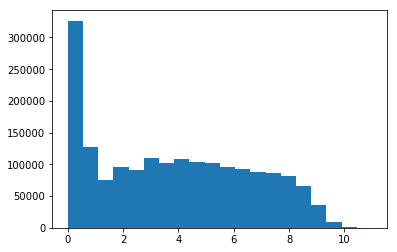

In [116]:
plt.hist(data.log_edge_weight, bins=20);

In [119]:
data.subject_id.unique().shape

(789,)

# Plan:


### LinReg on whole edges and log_edges
### LogReg on binary edges
### Tree methods

Remarks :

rewrite train-test splitting based on subject_id

In [4]:
from sklearn.linear_model import LinearRegression, Lasso, LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import mean_squared_error, r2_score, roc_auc_score

In [5]:
f_cols = ['i', 'j', 'vol1', 'thick1', 'area1', 'vol2', 'thick2',
          'area2', 'ar1_th1', 'vol1_th1', 'vol1_area1', 'vol1_bias', 'area1_bias',
          'thick1_bias', 'ar2_th2', 'vol2_th2', 'vol2_area2', 'vol2_bias',
          'area2_bias', 'thick2_bias']

t_cols = ['edge_weight', 'edge', 'log_edge_weight']

In [168]:
from catboost import CatBoostRegressor
from catboost import CatBoostClassifier

In [187]:
regressor = CatBoostRegressor(thread_count=8)

for train, test in subject_split(data, n_splits=1):
    
    target = data['edge_weight']
    X = data[f_cols]
    X_train, X_test, y_train, y_test = X[train], X[test], target[train], target[test]

    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    
    
    y_pred_train = regressor.predict(X_train)
    print('TRAIN mse: {:.2f} TRAIN r2: {:.5f}'.format(mean_squared_error(y_train, y_pred_train), 
                                                  r2_score(y_train, y_pred_train)))
    
    print('TEST mse: {:.2f} TEST r2: {:.5f}'.format(mean_squared_error(y_test, y_pred), 
                                                  r2_score(y_test, y_pred)))

0:	learn: 2154.8147183	total: 159ms	remaining: 2m 38s
1:	learn: 2137.5003267	total: 310ms	remaining: 2m 34s
2:	learn: 2120.8484830	total: 455ms	remaining: 2m 31s
3:	learn: 2103.2939986	total: 597ms	remaining: 2m 28s
4:	learn: 2088.2397267	total: 724ms	remaining: 2m 24s
5:	learn: 2074.0113296	total: 850ms	remaining: 2m 20s
6:	learn: 2060.1114180	total: 979ms	remaining: 2m 18s
7:	learn: 2045.2272691	total: 1.1s	remaining: 2m 16s
8:	learn: 2032.5834183	total: 1.23s	remaining: 2m 15s
9:	learn: 2020.6402251	total: 1.35s	remaining: 2m 13s
10:	learn: 2009.1446078	total: 1.48s	remaining: 2m 12s
11:	learn: 1997.3773051	total: 1.6s	remaining: 2m 11s
12:	learn: 1984.8753312	total: 1.73s	remaining: 2m 11s
13:	learn: 1972.9820063	total: 1.86s	remaining: 2m 10s
14:	learn: 1962.5580375	total: 1.98s	remaining: 2m 10s
15:	learn: 1953.3083287	total: 2.11s	remaining: 2m 9s
16:	learn: 1944.4569340	total: 2.23s	remaining: 2m 9s
17:	learn: 1933.9102281	total: 2.36s	remaining: 2m 8s
18:	learn: 1924.4900347	t

148:	learn: 1623.1838202	total: 22.8s	remaining: 2m 12s
149:	learn: 1622.1005380	total: 22.9s	remaining: 2m 11s
150:	learn: 1621.1950083	total: 23.1s	remaining: 2m 11s
151:	learn: 1620.3233590	total: 23.2s	remaining: 2m 11s
152:	learn: 1619.1956421	total: 23.4s	remaining: 2m 11s
153:	learn: 1618.3139008	total: 23.5s	remaining: 2m 10s
154:	learn: 1617.5619357	total: 23.6s	remaining: 2m 10s
155:	learn: 1616.5946057	total: 23.8s	remaining: 2m 10s
156:	learn: 1615.9327425	total: 23.9s	remaining: 2m 10s
157:	learn: 1615.0053843	total: 24s	remaining: 2m 9s
158:	learn: 1614.4616226	total: 24.2s	remaining: 2m 9s
159:	learn: 1613.5598570	total: 24.3s	remaining: 2m 9s
160:	learn: 1612.4859198	total: 24.5s	remaining: 2m 9s
161:	learn: 1611.8732141	total: 24.6s	remaining: 2m 8s
162:	learn: 1610.9331359	total: 24.7s	remaining: 2m 8s
163:	learn: 1610.1921684	total: 24.9s	remaining: 2m 8s
164:	learn: 1609.3415206	total: 25s	remaining: 2m 8s
165:	learn: 1608.4820996	total: 25.1s	remaining: 2m 7s
166:	

296:	learn: 1523.9582695	total: 41.9s	remaining: 1m 39s
297:	learn: 1523.5029010	total: 42s	remaining: 1m 39s
298:	learn: 1523.1071334	total: 42.2s	remaining: 1m 39s
299:	learn: 1522.6792999	total: 42.3s	remaining: 1m 39s
300:	learn: 1522.0118093	total: 42.4s	remaining: 1m 39s
301:	learn: 1521.0939418	total: 42.5s	remaining: 1m 38s
302:	learn: 1520.7394742	total: 42.7s	remaining: 1m 38s
303:	learn: 1520.4738542	total: 42.8s	remaining: 1m 38s
304:	learn: 1519.8174471	total: 42.9s	remaining: 1m 38s
305:	learn: 1519.4382842	total: 43s	remaining: 1m 38s
306:	learn: 1519.0139286	total: 43.1s	remaining: 1m 37s
307:	learn: 1518.3943897	total: 43.3s	remaining: 1m 37s
308:	learn: 1518.1458493	total: 43.4s	remaining: 1m 37s
309:	learn: 1517.5848604	total: 43.5s	remaining: 1m 37s
310:	learn: 1517.4691771	total: 43.6s	remaining: 1m 37s
311:	learn: 1517.0966257	total: 43.7s	remaining: 1m 37s
312:	learn: 1516.7534181	total: 43.9s	remaining: 1m 36s
313:	learn: 1516.2617212	total: 44s	remaining: 1m 36


Iteration with suspicious time -2.06 sec ignored in overall statistics.
442:	learn: 1455.4692299	total: 1m 1s	remaining: 1m 18s
443:	learn: 1455.0895533	total: 1m 2s	remaining: 1m 18s
444:	learn: 1454.6369316	total: 1m 4s	remaining: 1m 21s
445:	learn: 1454.4917133	total: 1m 4s	remaining: 1m 20s
446:	learn: 1454.0277854	total: 1m 4s	remaining: 1m 20s
447:	learn: 1453.7209709	total: 1m 4s	remaining: 1m 20s
448:	learn: 1453.1062766	total: 1m 4s	remaining: 1m 20s
449:	learn: 1452.8094231	total: 1m 5s	remaining: 1m 20s
450:	learn: 1452.5248618	total: 1m 5s	remaining: 1m 19s
451:	learn: 1452.1775805	total: 1m 5s	remaining: 1m 19s
452:	learn: 1451.7345473	total: 1m 5s	remaining: 1m 19s
453:	learn: 1451.4635733	total: 1m 5s	remaining: 1m 19s
454:	learn: 1451.0129973	total: 1m 5s	remaining: 1m 19s
455:	learn: 1450.5727701	total: 1m 5s	remaining: 1m 19s
456:	learn: 1450.1497620	total: 1m 5s	remaining: 1m 18s
457:	learn: 1449.7039321	total: 1m 5s	remaining: 1m 18s
458:	learn: 1449.2378244	total:

586:	learn: 1402.6382034	total: 1m 24s	remaining: 59.8s
587:	learn: 1402.0730866	total: 1m 24s	remaining: 59.7s
588:	learn: 1401.9599387	total: 1m 24s	remaining: 59.5s
589:	learn: 1401.3560705	total: 1m 24s	remaining: 59.3s
590:	learn: 1400.9451805	total: 1m 24s	remaining: 59.2s
591:	learn: 1400.6111157	total: 1m 24s	remaining: 59s
592:	learn: 1400.3570112	total: 1m 25s	remaining: 58.9s
593:	learn: 1400.0933192	total: 1m 25s	remaining: 58.7s
594:	learn: 1399.8369168	total: 1m 25s	remaining: 58.6s
595:	learn: 1399.4980025	total: 1m 25s	remaining: 58.4s
596:	learn: 1399.2787384	total: 1m 25s	remaining: 58.2s
597:	learn: 1399.1395087	total: 1m 25s	remaining: 58.1s
598:	learn: 1398.6966354	total: 1m 25s	remaining: 57.9s
599:	learn: 1398.2792324	total: 1m 25s	remaining: 57.8s
600:	learn: 1397.9557105	total: 1m 26s	remaining: 57.6s
601:	learn: 1397.7576094	total: 1m 26s	remaining: 57.4s
602:	learn: 1397.4488434	total: 1m 26s	remaining: 57.3s
603:	learn: 1397.3053494	total: 1m 26s	remaining: 

734:	learn: 1356.4517936	total: 1m 42s	remaining: 37.3s
735:	learn: 1356.1978396	total: 1m 42s	remaining: 37.1s
736:	learn: 1355.9902870	total: 1m 42s	remaining: 37s
737:	learn: 1355.4802601	total: 1m 43s	remaining: 36.8s
738:	learn: 1355.1615800	total: 1m 43s	remaining: 36.7s
739:	learn: 1354.7977755	total: 1m 43s	remaining: 36.5s
740:	learn: 1354.6656386	total: 1m 43s	remaining: 36.4s
741:	learn: 1354.4854134	total: 1m 43s	remaining: 36.2s
742:	learn: 1354.1377886	total: 1m 43s	remaining: 36.1s
743:	learn: 1353.9592485	total: 1m 43s	remaining: 35.9s
744:	learn: 1353.7320723	total: 1m 43s	remaining: 35.8s
745:	learn: 1353.2505480	total: 1m 44s	remaining: 35.7s
746:	learn: 1353.1167528	total: 1m 44s	remaining: 35.5s
747:	learn: 1352.7123476	total: 1m 44s	remaining: 35.4s
748:	learn: 1352.5661158	total: 1m 44s	remaining: 35.2s
749:	learn: 1352.1470427	total: 1m 44s	remaining: 35.1s
750:	learn: 1351.6859939	total: 1m 44s	remaining: 34.9s
751:	learn: 1351.5740247	total: 1m 44s	remaining: 

882:	learn: 1319.6237209	total: 2m 1s	remaining: 16.1s
883:	learn: 1319.3726312	total: 2m 1s	remaining: 16s
884:	learn: 1319.3076512	total: 2m 1s	remaining: 15.8s
885:	learn: 1319.0496472	total: 2m 1s	remaining: 15.7s
886:	learn: 1318.9070434	total: 2m 1s	remaining: 15.6s
887:	learn: 1318.7672321	total: 2m 1s	remaining: 15.4s
888:	learn: 1318.5784557	total: 2m 1s	remaining: 15.3s
889:	learn: 1318.4082373	total: 2m 1s	remaining: 15.1s
890:	learn: 1318.0762302	total: 2m 2s	remaining: 15s
891:	learn: 1317.7755666	total: 2m 2s	remaining: 14.9s
892:	learn: 1317.6459792	total: 2m 2s	remaining: 14.7s
893:	learn: 1317.4081396	total: 2m 2s	remaining: 14.6s
894:	learn: 1317.0825811	total: 2m 2s	remaining: 14.4s
895:	learn: 1316.9405949	total: 2m 2s	remaining: 14.3s
896:	learn: 1316.7666504	total: 2m 2s	remaining: 14.2s
897:	learn: 1316.3917227	total: 2m 2s	remaining: 14s
898:	learn: 1316.3059512	total: 2m 2s	remaining: 13.9s
899:	learn: 1316.2318237	total: 2m 3s	remaining: 13.8s
900:	learn: 1316

In [188]:
print('TRAIN mse: {:.2f} TRAIN r2: {:.5f}'.format(mean_squared_error(y_train, y_pred_train), 
                                                  r2_score(y_train, y_pred_train)))
    
print('TEST mse: {:.2f} TEST r2: {:.5f}'.format(mean_squared_error(y_test, y_pred), 
                                                  r2_score(y_test, y_pred)))

TRAIN mse: 1672926.33 TRAIN r2: 0.59258
TEST mse: 1690985.49 TEST r2: 0.59098


In [190]:
test.sum()

594558

In [198]:
cols = ['subject_id', 'i', 'j', 'edge_weight']
test = data[test][cols].copy()

In [224]:
for f, imp in zip(f_cols, regressor.feature_importances_):
    print(f,'          ', imp)

i            27.812803971961486
j            28.365877497632674
vol1            6.427500418688342
thick1            1.0345076992000948
area1            0.39620525429684744
vol2            6.734865580334053
thick2            0.5176474737864297
area2            2.2710008468212837
ar1_th1            2.3051464071335634
vol1_th1            1.7047522466898164
vol1_area1            4.205922765026187
vol1_bias            1.8764208042007064
area1_bias            0.9565120820599994
thick1_bias            0.1870020886085184
ar2_th2            2.8304759112341666
vol2_th2            3.631866610923609
vol2_area2            4.966205438584841
vol2_bias            1.2918751639409847
area2_bias            2.304894702488042
thick2_bias            0.1785170363883616


In [199]:
y_pred

array([  708.34090779,  1086.46507528,    36.76367617, ...,    29.06116047,
         608.6900697 ,  1266.36180411])

In [203]:
test['edge_weight_predicted'] = y_pred

In [215]:
individual_idx = test['subject_id'] == 13.0

In [216]:
test[individual_idx]

,subject_id,i,j,edge_weight,edge_weight_predicted
29614,13.0,0.0,1.0,1.0,708.340908
29615,13.0,0.0,2.0,2344.0,1086.465075
29616,13.0,0.0,3.0,331.0,36.763676
29617,13.0,0.0,4.0,0.0,99.436988
29618,13.0,0.0,5.0,1175.0,1585.949799
29619,13.0,0.0,6.0,8050.0,3637.363790
29620,13.0,0.0,7.0,10473.0,2501.281126
29621,13.0,0.0,8.0,531.0,305.487178
29622,13.0,0.0,9.0,3444.0,957.230330
29623,13.0,0.0,10.0,122.0,598.059908


In [ ]:
def restore_matrix(data, subject_id):
    
    individual_idx = data['subject_id'] == float(subject_id)
    test[individual_idx] 

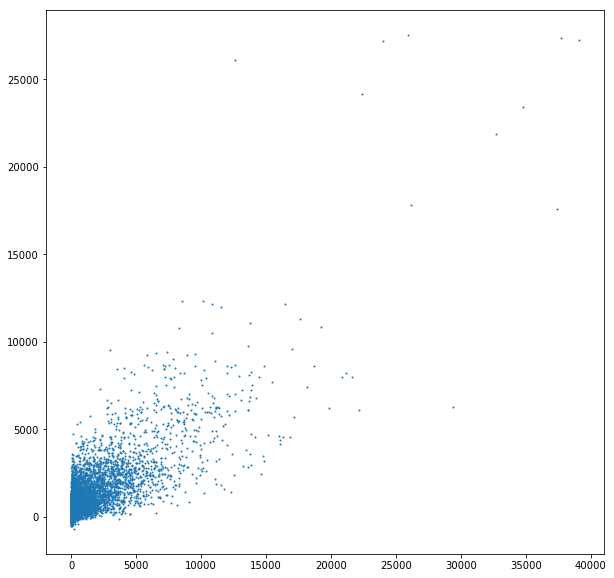

In [209]:
plt.figure(figsize=(10,10))
plt.scatter(y_test[0:-1:50], y_pred[0:-1:50], s=1)

In [186]:
regressor = CatBoostRegressor(thread_count=8)

for train, test in subject_split(data, n_splits=1):
    
    target = data['log_edge_weight']
    X = data[f_cols]
    X_train, X_test, y_train, y_test = X[train], X[test], target[train], target[test]
    
    original_target = data['edge_weight']
    original_y_train, original_y_test = original_target[train], original_target[test]
    
    
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    y_pred_train = regressor.predict(X_train)
    
    original_y_pred = np.expm1(y_pred)
    original_y_pred_train = np.expm1(y_pred_train)
    
    
    print('TRAIN mse: {:.2f} TRAIN r2: {:.5f}'.format(mean_squared_error(y_train, y_pred_train), 
                                                  r2_score(y_train, y_pred_train)))
    
    print('TEST mse: {:.2f} TEST r2: {:.5f}'.format(mean_squared_error(y_test, y_pred), 
                                                  r2_score(y_test, y_pred)))
    
    print('TRAIN mse: {:.2f} TRAIN r2: {:.5f}'.format(mean_squared_error(original_y_train, original_y_pred_train), 
                                                  r2_score(original_y_train, original_y_pred_train)))
    
    print('TEST mse: {:.2f} TEST r2: {:.5f}'.format(mean_squared_error(y_test, y_pred), 
                                                  r2_score(original_y_test, original_y_pred)))

0:	learn: 4.6194088	total: 154ms	remaining: 2m 34s
1:	learn: 4.5152756	total: 280ms	remaining: 2m 19s
2:	learn: 4.4149949	total: 416ms	remaining: 2m 18s
3:	learn: 4.3185069	total: 537ms	remaining: 2m 13s
4:	learn: 4.2256600	total: 670ms	remaining: 2m 13s
5:	learn: 4.1363942	total: 803ms	remaining: 2m 13s
6:	learn: 4.0505597	total: 930ms	remaining: 2m 11s
7:	learn: 3.9680065	total: 1.05s	remaining: 2m 9s
8:	learn: 3.8887590	total: 1.17s	remaining: 2m 9s
9:	learn: 3.8126340	total: 1.3s	remaining: 2m 8s
10:	learn: 3.7395004	total: 1.43s	remaining: 2m 8s
11:	learn: 3.6688906	total: 1.55s	remaining: 2m 7s
12:	learn: 3.6009700	total: 1.68s	remaining: 2m 7s
13:	learn: 3.5361249	total: 1.81s	remaining: 2m 7s
14:	learn: 3.4733318	total: 1.93s	remaining: 2m 6s
15:	learn: 3.4134745	total: 2.06s	remaining: 2m 6s
16:	learn: 3.3559360	total: 2.19s	remaining: 2m 6s
17:	learn: 3.3008081	total: 2.32s	remaining: 2m 6s
18:	learn: 3.2478372	total: 2.45s	remaining: 2m 6s
19:	learn: 3.1971219	total: 2.58s	r

160:	learn: 2.0403929	total: 20s	remaining: 1m 44s
161:	learn: 2.0389744	total: 20.1s	remaining: 1m 44s
162:	learn: 2.0380152	total: 20.3s	remaining: 1m 43s
163:	learn: 2.0369923	total: 20.4s	remaining: 1m 43s
164:	learn: 2.0357847	total: 20.5s	remaining: 1m 43s
165:	learn: 2.0350916	total: 20.6s	remaining: 1m 43s
166:	learn: 2.0341465	total: 20.7s	remaining: 1m 43s
167:	learn: 2.0332958	total: 20.9s	remaining: 1m 43s
168:	learn: 2.0322725	total: 21s	remaining: 1m 43s
169:	learn: 2.0312068	total: 21.1s	remaining: 1m 42s
170:	learn: 2.0304370	total: 21.2s	remaining: 1m 42s
171:	learn: 2.0292576	total: 21.3s	remaining: 1m 42s
172:	learn: 2.0284881	total: 21.5s	remaining: 1m 42s
173:	learn: 2.0273893	total: 21.6s	remaining: 1m 42s
174:	learn: 2.0265146	total: 21.7s	remaining: 1m 42s
175:	learn: 2.0251166	total: 21.8s	remaining: 1m 42s
176:	learn: 2.0241975	total: 21.9s	remaining: 1m 42s
177:	learn: 2.0231907	total: 22.1s	remaining: 1m 41s
178:	learn: 2.0222433	total: 22.2s	remaining: 1m 4

316:	learn: 1.9199610	total: 39.6s	remaining: 1m 25s
317:	learn: 1.9194864	total: 39.7s	remaining: 1m 25s
318:	learn: 1.9186681	total: 39.9s	remaining: 1m 25s
319:	learn: 1.9179239	total: 40s	remaining: 1m 25s
320:	learn: 1.9174286	total: 40.1s	remaining: 1m 24s
321:	learn: 1.9168615	total: 40.3s	remaining: 1m 24s
322:	learn: 1.9163605	total: 40.4s	remaining: 1m 24s
323:	learn: 1.9158590	total: 40.5s	remaining: 1m 24s
324:	learn: 1.9154425	total: 40.7s	remaining: 1m 24s
325:	learn: 1.9148898	total: 40.8s	remaining: 1m 24s
326:	learn: 1.9141462	total: 40.9s	remaining: 1m 24s
327:	learn: 1.9137539	total: 41.1s	remaining: 1m 24s
328:	learn: 1.9131395	total: 41.2s	remaining: 1m 24s
329:	learn: 1.9125251	total: 41.3s	remaining: 1m 23s
330:	learn: 1.9117937	total: 41.5s	remaining: 1m 23s
331:	learn: 1.9112814	total: 41.6s	remaining: 1m 23s
332:	learn: 1.9109273	total: 41.7s	remaining: 1m 23s
333:	learn: 1.9102141	total: 41.9s	remaining: 1m 23s
334:	learn: 1.9098978	total: 42s	remaining: 1m 2

472:	learn: 1.8400131	total: 59.2s	remaining: 1m 5s
473:	learn: 1.8397672	total: 59.3s	remaining: 1m 5s
474:	learn: 1.8393933	total: 59.5s	remaining: 1m 5s
475:	learn: 1.8389788	total: 59.6s	remaining: 1m 5s
476:	learn: 1.8384893	total: 59.7s	remaining: 1m 5s
477:	learn: 1.8381667	total: 59.9s	remaining: 1m 5s
478:	learn: 1.8377686	total: 60s	remaining: 1m 5s
479:	learn: 1.8374175	total: 1m	remaining: 1m 5s
480:	learn: 1.8372223	total: 1m	remaining: 1m 5s
481:	learn: 1.8367779	total: 1m	remaining: 1m 4s
482:	learn: 1.8364815	total: 1m	remaining: 1m 4s
483:	learn: 1.8360793	total: 1m	remaining: 1m 4s
484:	learn: 1.8356905	total: 1m	remaining: 1m 4s
485:	learn: 1.8353041	total: 1m	remaining: 1m 4s
486:	learn: 1.8348069	total: 1m	remaining: 1m 4s
487:	learn: 1.8344245	total: 1m 1s	remaining: 1m 4s
488:	learn: 1.8339861	total: 1m 1s	remaining: 1m 4s
489:	learn: 1.8335249	total: 1m 1s	remaining: 1m 3s
490:	learn: 1.8331205	total: 1m 1s	remaining: 1m 3s
491:	learn: 1.8327447	total: 1m 1s	rem

630:	learn: 1.7799513	total: 1m 19s	remaining: 46.4s
631:	learn: 1.7796826	total: 1m 19s	remaining: 46.3s
632:	learn: 1.7793793	total: 1m 19s	remaining: 46.2s
633:	learn: 1.7791702	total: 1m 19s	remaining: 46s
634:	learn: 1.7787189	total: 1m 19s	remaining: 45.9s
635:	learn: 1.7784306	total: 1m 20s	remaining: 45.8s
636:	learn: 1.7779835	total: 1m 20s	remaining: 45.7s
637:	learn: 1.7774616	total: 1m 20s	remaining: 45.6s
638:	learn: 1.7771810	total: 1m 20s	remaining: 45.5s
639:	learn: 1.7769076	total: 1m 20s	remaining: 45.3s
640:	learn: 1.7767098	total: 1m 20s	remaining: 45.2s
641:	learn: 1.7764064	total: 1m 20s	remaining: 45.1s
642:	learn: 1.7760597	total: 1m 21s	remaining: 45s
643:	learn: 1.7758254	total: 1m 21s	remaining: 44.8s
644:	learn: 1.7754755	total: 1m 21s	remaining: 44.7s
645:	learn: 1.7750364	total: 1m 21s	remaining: 44.6s
646:	learn: 1.7746550	total: 1m 21s	remaining: 44.5s
647:	learn: 1.7744879	total: 1m 21s	remaining: 44.4s
648:	learn: 1.7742354	total: 1m 21s	remaining: 44.

786:	learn: 1.7331940	total: 1m 39s	remaining: 26.8s
787:	learn: 1.7328806	total: 1m 39s	remaining: 26.7s
788:	learn: 1.7325387	total: 1m 39s	remaining: 26.6s
789:	learn: 1.7323532	total: 1m 39s	remaining: 26.4s
790:	learn: 1.7320928	total: 1m 39s	remaining: 26.3s
791:	learn: 1.7316746	total: 1m 39s	remaining: 26.2s
792:	learn: 1.7315993	total: 1m 39s	remaining: 26.1s
793:	learn: 1.7313805	total: 1m 39s	remaining: 25.9s
794:	learn: 1.7311674	total: 1m 40s	remaining: 25.8s
795:	learn: 1.7309427	total: 1m 40s	remaining: 25.7s
796:	learn: 1.7306596	total: 1m 40s	remaining: 25.6s
797:	learn: 1.7302280	total: 1m 40s	remaining: 25.4s
798:	learn: 1.7300032	total: 1m 40s	remaining: 25.3s
799:	learn: 1.7297529	total: 1m 40s	remaining: 25.2s
800:	learn: 1.7294052	total: 1m 40s	remaining: 25.1s
801:	learn: 1.7290922	total: 1m 41s	remaining: 24.9s
802:	learn: 1.7287910	total: 1m 41s	remaining: 24.8s
803:	learn: 1.7286233	total: 1m 41s	remaining: 24.7s
804:	learn: 1.7283669	total: 1m 41s	remaining:

942:	learn: 1.6932423	total: 1m 58s	remaining: 7.17s
943:	learn: 1.6929801	total: 1m 58s	remaining: 7.04s
944:	learn: 1.6928593	total: 1m 58s	remaining: 6.92s
945:	learn: 1.6926731	total: 1m 59s	remaining: 6.79s
946:	learn: 1.6924562	total: 1m 59s	remaining: 6.67s
947:	learn: 1.6922407	total: 1m 59s	remaining: 6.54s
948:	learn: 1.6920632	total: 1m 59s	remaining: 6.42s
949:	learn: 1.6918757	total: 1m 59s	remaining: 6.29s
950:	learn: 1.6917656	total: 1m 59s	remaining: 6.17s
951:	learn: 1.6916427	total: 1m 59s	remaining: 6.04s
952:	learn: 1.6914286	total: 1m 59s	remaining: 5.91s
953:	learn: 1.6911300	total: 2m	remaining: 5.79s
954:	learn: 1.6909274	total: 2m	remaining: 5.66s
955:	learn: 1.6907708	total: 2m	remaining: 5.54s
956:	learn: 1.6902766	total: 2m	remaining: 5.41s
957:	learn: 1.6900945	total: 2m	remaining: 5.28s
958:	learn: 1.6896438	total: 2m	remaining: 5.16s
959:	learn: 1.6893593	total: 2m	remaining: 5.03s
960:	learn: 1.6890293	total: 2m	remaining: 4.91s
961:	learn: 1.6887994	tot

100:	learn: 2.1188542	total: 12.7s	remaining: 1m 53s
101:	learn: 2.1172680	total: 12.8s	remaining: 1m 52s
102:	learn: 2.1156105	total: 13s	remaining: 1m 52s
103:	learn: 2.1132150	total: 13.1s	remaining: 1m 52s
104:	learn: 2.1111971	total: 13.2s	remaining: 1m 52s
105:	learn: 2.1094906	total: 13.4s	remaining: 1m 52s
106:	learn: 2.1077713	total: 13.5s	remaining: 1m 52s
107:	learn: 2.1061247	total: 13.6s	remaining: 1m 52s
108:	learn: 2.1048731	total: 13.8s	remaining: 1m 52s
109:	learn: 2.1030710	total: 13.9s	remaining: 1m 52s
110:	learn: 2.1015831	total: 14s	remaining: 1m 52s
111:	learn: 2.1000342	total: 14.1s	remaining: 1m 52s
112:	learn: 2.0981402	total: 14.3s	remaining: 1m 52s
113:	learn: 2.0966580	total: 14.4s	remaining: 1m 51s
114:	learn: 2.0948992	total: 14.5s	remaining: 1m 51s
115:	learn: 2.0931559	total: 14.7s	remaining: 1m 51s
116:	learn: 2.0913427	total: 14.8s	remaining: 1m 51s
117:	learn: 2.0900418	total: 14.9s	remaining: 1m 51s
118:	learn: 2.0885326	total: 15.1s	remaining: 1m 5

256:	learn: 1.9575932	total: 32s	remaining: 1m 32s
257:	learn: 1.9566958	total: 32.1s	remaining: 1m 32s
258:	learn: 1.9560279	total: 32.3s	remaining: 1m 32s
259:	learn: 1.9554338	total: 32.4s	remaining: 1m 32s
260:	learn: 1.9546514	total: 32.5s	remaining: 1m 32s
261:	learn: 1.9543903	total: 32.6s	remaining: 1m 31s
262:	learn: 1.9537552	total: 32.7s	remaining: 1m 31s
263:	learn: 1.9528652	total: 32.9s	remaining: 1m 31s
264:	learn: 1.9523539	total: 33s	remaining: 1m 31s
265:	learn: 1.9519973	total: 33.1s	remaining: 1m 31s
266:	learn: 1.9514306	total: 33.2s	remaining: 1m 31s
267:	learn: 1.9508837	total: 33.4s	remaining: 1m 31s
268:	learn: 1.9501661	total: 33.5s	remaining: 1m 30s
269:	learn: 1.9496529	total: 33.6s	remaining: 1m 30s
270:	learn: 1.9491619	total: 33.7s	remaining: 1m 30s
271:	learn: 1.9486356	total: 33.8s	remaining: 1m 30s
272:	learn: 1.9478890	total: 34s	remaining: 1m 30s
273:	learn: 1.9467041	total: 34.1s	remaining: 1m 30s
274:	learn: 1.9460158	total: 34.2s	remaining: 1m 30s

412:	learn: 1.8679120	total: 51.3s	remaining: 1m 12s
413:	learn: 1.8675471	total: 51.5s	remaining: 1m 12s
414:	learn: 1.8668134	total: 51.6s	remaining: 1m 12s
415:	learn: 1.8661618	total: 51.7s	remaining: 1m 12s
416:	learn: 1.8655452	total: 51.8s	remaining: 1m 12s
417:	learn: 1.8647371	total: 52s	remaining: 1m 12s
418:	learn: 1.8643285	total: 52.1s	remaining: 1m 12s
419:	learn: 1.8635413	total: 52.2s	remaining: 1m 12s
420:	learn: 1.8628533	total: 52.3s	remaining: 1m 11s
421:	learn: 1.8622016	total: 52.5s	remaining: 1m 11s
422:	learn: 1.8616634	total: 52.6s	remaining: 1m 11s
423:	learn: 1.8613614	total: 52.7s	remaining: 1m 11s
424:	learn: 1.8608561	total: 52.9s	remaining: 1m 11s
425:	learn: 1.8605108	total: 53s	remaining: 1m 11s
426:	learn: 1.8597140	total: 53.1s	remaining: 1m 11s
427:	learn: 1.8593854	total: 53.2s	remaining: 1m 11s
428:	learn: 1.8590532	total: 53.3s	remaining: 1m 10s
429:	learn: 1.8586165	total: 53.4s	remaining: 1m 10s
430:	learn: 1.8580487	total: 53.6s	remaining: 1m 1

572:	learn: 1.7959442	total: 1m 11s	remaining: 53.1s
573:	learn: 1.7956438	total: 1m 11s	remaining: 53s
574:	learn: 1.7953389	total: 1m 11s	remaining: 52.9s
575:	learn: 1.7949934	total: 1m 11s	remaining: 52.7s
576:	learn: 1.7946636	total: 1m 11s	remaining: 52.6s
577:	learn: 1.7941598	total: 1m 11s	remaining: 52.5s
578:	learn: 1.7938109	total: 1m 12s	remaining: 52.4s
579:	learn: 1.7932815	total: 1m 12s	remaining: 52.2s
580:	learn: 1.7929903	total: 1m 12s	remaining: 52.1s
581:	learn: 1.7926084	total: 1m 12s	remaining: 52s
582:	learn: 1.7923848	total: 1m 12s	remaining: 51.8s
583:	learn: 1.7919018	total: 1m 12s	remaining: 51.7s
584:	learn: 1.7916006	total: 1m 12s	remaining: 51.6s
585:	learn: 1.7913341	total: 1m 12s	remaining: 51.5s
586:	learn: 1.7909939	total: 1m 12s	remaining: 51.3s
587:	learn: 1.7905855	total: 1m 13s	remaining: 51.2s
588:	learn: 1.7902596	total: 1m 13s	remaining: 51.1s
589:	learn: 1.7898946	total: 1m 13s	remaining: 51s
590:	learn: 1.7895576	total: 1m 13s	remaining: 50.8s

728:	learn: 1.7440132	total: 1m 30s	remaining: 33.8s
729:	learn: 1.7438314	total: 1m 30s	remaining: 33.7s
730:	learn: 1.7436530	total: 1m 31s	remaining: 33.5s
731:	learn: 1.7433618	total: 1m 31s	remaining: 33.4s
732:	learn: 1.7429111	total: 1m 31s	remaining: 33.3s
733:	learn: 1.7427753	total: 1m 31s	remaining: 33.2s
734:	learn: 1.7425872	total: 1m 31s	remaining: 33s
735:	learn: 1.7422902	total: 1m 31s	remaining: 32.9s
736:	learn: 1.7420974	total: 1m 31s	remaining: 32.8s
737:	learn: 1.7418363	total: 1m 31s	remaining: 32.6s
738:	learn: 1.7415721	total: 1m 32s	remaining: 32.5s
739:	learn: 1.7411789	total: 1m 32s	remaining: 32.4s
740:	learn: 1.7408256	total: 1m 32s	remaining: 32.3s
741:	learn: 1.7404897	total: 1m 32s	remaining: 32.1s
742:	learn: 1.7402313	total: 1m 32s	remaining: 32s
743:	learn: 1.7401609	total: 1m 32s	remaining: 31.9s
744:	learn: 1.7398210	total: 1m 32s	remaining: 31.8s
745:	learn: 1.7394398	total: 1m 32s	remaining: 31.6s
746:	learn: 1.7391047	total: 1m 33s	remaining: 31.

884:	learn: 1.7016120	total: 1m 50s	remaining: 14.3s
885:	learn: 1.7012783	total: 1m 50s	remaining: 14.2s
886:	learn: 1.7011296	total: 1m 50s	remaining: 14.1s
887:	learn: 1.7009051	total: 1m 50s	remaining: 13.9s
888:	learn: 1.7007035	total: 1m 50s	remaining: 13.8s
889:	learn: 1.7004140	total: 1m 50s	remaining: 13.7s
890:	learn: 1.7001897	total: 1m 50s	remaining: 13.6s
891:	learn: 1.7000486	total: 1m 51s	remaining: 13.4s
892:	learn: 1.6997576	total: 1m 51s	remaining: 13.3s
893:	learn: 1.6995390	total: 1m 51s	remaining: 13.2s
894:	learn: 1.6993299	total: 1m 51s	remaining: 13.1s
895:	learn: 1.6989952	total: 1m 51s	remaining: 13s
896:	learn: 1.6985354	total: 1m 51s	remaining: 12.8s
897:	learn: 1.6982733	total: 1m 51s	remaining: 12.7s
898:	learn: 1.6977756	total: 1m 51s	remaining: 12.6s
899:	learn: 1.6975572	total: 1m 52s	remaining: 12.5s
900:	learn: 1.6973308	total: 1m 52s	remaining: 12.3s
901:	learn: 1.6969979	total: 1m 52s	remaining: 12.2s
902:	learn: 1.6968104	total: 1m 52s	remaining: 1

40:	learn: 2.5232681	total: 5.46s	remaining: 2m 7s
41:	learn: 2.5049259	total: 5.59s	remaining: 2m 7s
42:	learn: 2.4872540	total: 5.71s	remaining: 2m 7s
43:	learn: 2.4706805	total: 5.83s	remaining: 2m 6s
44:	learn: 2.4545876	total: 5.95s	remaining: 2m 6s
45:	learn: 2.4393773	total: 6.08s	remaining: 2m 6s
46:	learn: 2.4247572	total: 6.2s	remaining: 2m 5s
47:	learn: 2.4110897	total: 6.32s	remaining: 2m 5s
48:	learn: 2.3969376	total: 6.45s	remaining: 2m 5s
49:	learn: 2.3844001	total: 6.59s	remaining: 2m 5s
50:	learn: 2.3723528	total: 6.72s	remaining: 2m 5s
51:	learn: 2.3610887	total: 6.85s	remaining: 2m 4s
52:	learn: 2.3499722	total: 6.97s	remaining: 2m 4s
53:	learn: 2.3399198	total: 7.09s	remaining: 2m 4s
54:	learn: 2.3302128	total: 7.21s	remaining: 2m 3s
55:	learn: 2.3212249	total: 7.33s	remaining: 2m 3s
56:	learn: 2.3122579	total: 7.46s	remaining: 2m 3s
57:	learn: 2.3030201	total: 7.59s	remaining: 2m 3s
58:	learn: 2.2952379	total: 7.71s	remaining: 2m 2s

Iteration with suspicious time 


Iteration with suspicious time -2.03 sec ignored in overall statistics.
192:	learn: 2.0133338	total: 32.9s	remaining: 2m 21s
193:	learn: 2.0123102	total: 33.1s	remaining: 2m 21s
194:	learn: 2.0109467	total: 33.2s	remaining: 2m 20s
195:	learn: 2.0097438	total: 33.3s	remaining: 2m 20s
196:	learn: 2.0089129	total: 33.4s	remaining: 2m 19s
197:	learn: 2.0078944	total: 33.6s	remaining: 2m 19s
198:	learn: 2.0071630	total: 33.7s	remaining: 2m 19s
199:	learn: 2.0060415	total: 33.8s	remaining: 2m 18s
200:	learn: 2.0050279	total: 34s	remaining: 2m 18s
201:	learn: 2.0042442	total: 34.1s	remaining: 2m 18s
202:	learn: 2.0032420	total: 34.2s	remaining: 2m 17s
203:	learn: 2.0026539	total: 34.4s	remaining: 2m 17s
204:	learn: 2.0021960	total: 36.7s	remaining: 2m 25s
205:	learn: 2.0013965	total: 36.8s	remaining: 2m 25s
206:	learn: 2.0001680	total: 36.9s	remaining: 2m 24s
207:	learn: 1.9994654	total: 37s	remaining: 2m 24s
208:	learn: 1.9987579	total: 37.2s	remaining: 2m 24s
209:	learn: 1.9978624	total: 3

KeyboardInterrupt: 

In [ ]:
from sklearn.linear_model import SGDClassifier

In [9]:
regressor = LogisticRegression(penalty='l1', n_jobs=-1)

for train, test in subject_split(data, n_splits=1):
    
    target = data['edge']
    X = data[f_cols]
    X_train, X_test, y_train, y_test = X[train], X[test], target[train], target[test]
    
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict_proba(X_test)
    
    
    y_pred_train = regressor.predict_proba(X_train)
    
    
    print(roc_auc_score(y_train, y_pred_train[:, 1]))
    
    print(roc_auc_score(y_test, y_pred[:, 1]))

/nmnt/media/home/anvar/anaconda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


KeyboardInterrupt: 

In [ ]:
regressor.coef_

In [178]:
print('TRAIN mse: {:.2f} TRAIN r2: {:.5f}'.format(roc_auc_score(y_train, y_pred_train),))
    
print('TEST mse: {:.2f} TEST r2: {:.5f}'.format(roc_auc_score(y_test, y_pred_test),))

IndexError: tuple index out of range

In [180]:
y_pred_train.shape

(1202784,)

In [184]:
roc_auc_score(y_test, y_pred)

0.78788489870662248

In [182]:
roc_auc_score(y_train, y_pred_train)

0.79050896045543495

In [144]:
np.allclose(np.log1p(data['edge_weight']).values, data['log_edge_weight'].values)

True

In [152]:
y_train.mean()

3.794661045074463

In [153]:
y_test.mean(), y_pred.mean()

(3.801593780517578, 786.24587591184911)

In [154]:
regressor.coef_

array([  5.25371790e-02,  -4.31960076e-02,  -2.51163946e+01,
        -8.29765924e-01,  -9.79107977e+01,  -5.45268764e+01,
        -9.08824634e-01,  -4.24007435e+01,   5.75405990e+01,
         1.87331516e+02,   1.49443343e+00,   8.26569936e+01,
         2.85242314e+02,   2.32419935e+00,   2.35414202e+01,
        -1.65473200e+01,  -1.08795823e+00,   7.80682966e+01,
         2.58534235e+01,  -1.79133598e-01])

In [157]:
regressor.coef_

array([  2.50818749e+01,  -2.21673121e+01,  -3.27643431e+04,
        -1.73720963e+02,  -2.22598556e+03,  -1.16363056e+05,
        -1.54712330e+02,   2.61188710e+04,   1.35711146e+04,
         1.96019360e+05,   7.04205657e+02,   4.63354577e+04,
         1.98245345e+05,   8.77926620e+02,  -6.86854001e+03,
         2.03573556e+05,  -3.33986999e+02,   1.09494516e+05,
         1.77454685e+05,  -1.79274669e+02])

In [155]:
2.58534235e+01

25.8534235

In [145]:
regressor = LinearRegression()

for train, test in subject_split(data):
    
    target = data['edge_weight']
    log_target = data['log_edge_weight']
    
    X = data[f_cols]
    X_train, X_test, log_y_train, log_y_test = X[train], X[test], log_target[train], log_target[test]
    
    y_train, y_test = target[train], target[test]
    
    regressor.fit(X_train, log_y_train)
    log_y_pred = lin_reg.predict(X_test)
    
    print('TEST mse: {:.2f} TEST r2: {:.5f}'.format(mean_squared_error(y_test, w_y_pred), 
                                                  r2_score(w_y_test, w_y_pred)))
    
#     y_pred = np.expm1(w_y_pred)
#     print('TEST mse: {:.2f} TEST r2: {:.5f}'.format(mean_squared_error(y_test, y_pred), 
#                                                   r2_score(y_test, y_pred)))

TEST mse: 3643454.67 TEST r2: -139228.44672
TEST mse: 3712845.66 TEST r2: -139228.44672
TEST mse: 3635611.82 TEST r2: -139228.44672


In [147]:
log_y_pred.mean()

786.24587591184911

In [148]:
log_y_train.mean()

3.794661045074463

In [133]:
w_y_pred

array([ 742.96048393,  954.33881561,  685.31396874, ..., -145.49375387,
        223.47416218,  691.39843631])

In [132]:
y_pred

array([              inf,               inf,   4.24692896e+297, ...,
        -1.00000000e+000,   1.13134610e+097,   1.86434244e+300])

In [88]:
data.edge.mean()

0.818385124206543

In [126]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred = lin_reg.predict(X_test)

print('Linear regression: ', mean_squared_error(y_test, y_pred), r2_score(y_test, y_pred))

# lasso = Lasso(0.03)
# lasso.fit(X_train, y_train)
# y_pred = lasso.predict(X_test)

# print('Lasso regression: ', mean_squared_error(y_test, y_pred), r2_score(y_test, y_pred))

Linear regression:  3610475.45168 0.11840081299


In [82]:
y_pred

array([ 4.51614155,  4.56155965,  4.83013138, ...,  4.83807065,
        2.64085684,  5.64507998])

In [83]:
np.exp(y_pred) - 1

array([  90.48193791,   94.73267331,  124.22741164, ...,  125.2255831 ,
         13.02521588,  281.89618235])

In [85]:
print('Linear regression: ', mean_squared_error(y_test,np.exp(y_pred) - 1), r2_score(y_test,np.exp(y_pred) - 1))

Linear regression:  4218533.16818 -0.0300735903667


In [110]:
log_reg  = LogisticRegression()

log_reg.fit(X_train, y_train)
y_pred = log_reg.predict_proba(X_test)

print(roc_auc_score(y_test, y_pred[:, 1]))

0.773148082425


(528,) (261,)
(528,) (261,)
(528,) (261,)


In [122]:
i = data.subject_id.isin(train)

In [124]:
data[f_cols][i]

,i,j,vol1,thick1,area1,vol2,thick2,area2,ar1_th1,vol1_th1,vol1_area1,vol1_bias,area1_bias,thick1_bias,ar2_th2,vol2_th2,vol2_area2,vol2_bias,area2_bias,thick2_bias
2278,0.0,1.0,0.006068,2.732503,0.006154,0.004228,3.286786,0.003507,0.016815,0.002221,0.986111,0.010747,-0.003933,-1.746392,0.011526,0.001286,1.205686,0.007298,-0.002220,-2.081100
2279,0.0,2.0,0.006068,2.732503,0.006154,0.016978,2.818191,0.016453,0.016815,0.002221,0.986111,0.010747,-0.003933,-1.746392,0.046366,0.006024,1.031935,0.029389,-0.010428,-1.786257
2280,0.0,3.0,0.006068,2.732503,0.006154,0.005452,2.020464,0.007447,0.016815,0.002221,0.986111,0.010747,-0.003933,-1.746392,0.015046,0.002698,0.732114,0.009594,-0.004749,-1.288350
2281,0.0,4.0,0.006068,2.732503,0.006154,0.002506,3.213618,0.002190,0.016815,0.002221,0.986111,0.010747,-0.003933,-1.746392,0.007039,0.000780,1.144229,0.004533,-0.001410,-2.069389
2282,0.0,5.0,0.006068,2.732503,0.006154,0.026768,2.999317,0.023989,0.016815,0.002221,0.986111,0.010747,-0.003933,-1.746392,0.071949,0.008925,1.115876,0.045181,-0.015064,-1.883442
2283,0.0,6.0,0.006068,2.732503,0.006154,0.025157,2.638277,0.026651,0.016815,0.002221,0.986111,0.010747,-0.003933,-1.746392,0.070312,0.009535,0.943951,0.045155,-0.017115,-1.694326
2284,0.0,7.0,0.006068,2.732503,0.006154,0.027240,2.963619,0.025349,0.016815,0.002221,0.986111,0.010747,-0.003933,-1.746392,0.075125,0.009191,1.074593,0.047885,-0.016158,-1.889026
2285,0.0,8.0,0.006068,2.732503,0.006154,0.004216,2.433753,0.004652,0.016815,0.002221,0.986111,0.010747,-0.003933,-1.746392,0.011321,0.001732,0.906469,0.007104,-0.002919,-1.527284
2286,0.0,9.0,0.006068,2.732503,0.006154,0.018455,2.266801,0.022621,0.016815,0.002221,0.986111,0.010747,-0.003933,-1.746392,0.051278,0.008141,0.815822,0.032823,-0.014480,-1.450979
2287,0.0,10.0,0.006068,2.732503,0.006154,0.018162,3.219367,0.015556,0.016815,0.002221,0.986111,0.010747,-0.003933,-1.746392,0.050079,0.005642,1.167581,0.031917,-0.009914,-2.051786
